In [2]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import matplotlib.pyplot as plt
from net_visualiser import DrawNN

## The Problem
We want to solve the following BVP $$y'' = -2,\quad0<x<1$$ $$y(0) = y(1) = 1$$ using a neural network. This BVP has analytic solution $$y = 1 + x(1-x)$$ which we will use to evaluate our solution. We take the approach of searching for trial solution of the form $$\hat{y} = x(1-x)N(x,\theta) + 1$$ where $N$ is the neural network we train. This trial solution aoutomatically satisfies the boundary conditions so there is not need to encoroporate them into the loss function. For the discrete points $(x_0,\dots,x_n)$, we train the neural network by minimising the following loss function
$$L = \frac{1}{n}\sum_{k=0}^n(\hat{y}(x_k)''+2)^2$$
Our network using one hidden layer of the form $$\sigma(Wx + b)$$ where $\theta\coloneq\{W,b\}$ are the parameters we seek to optimise. The function $\sigma$ is the chosen activation function. In this case, we choose to use the sigmoid activation function given 
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
## Training
After initilising the parameters, we forward-propagate them through the network. We then evalute the loss function with these parameters in order to use gradient descent. This is simple repeated calculation of the form $$\theta_{n+1} = \theta_n-\alpha\nabla_\theta L$$ where $L = L(x_k,\theta)$ is the loss function and $\theta$ are the parameters. How do we calculate $\nabla_\theta L$? For a network of $N$ layers, this vector is given $$\nabla_\theta L = \left(\frac{\partial L}{\partial W^{(1)}},\dots,\frac{\partial L}{\partial W^{(N)}}, \frac{\partial L}{\partial b^{(1)}},\dots,\frac{\partial L}{\partial b^{(N)}}\right)$$ 

In [8]:
def analytic(x):
    return 1 + x*(1-x)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def initialise_params(architecture): # will generalise later
    W1 = np.random.randn(architecture[1], architecture[0])* 0.01
    b1 = np.random.randn(architecture[1], 1)
    return [W1, b1]

def neural_network(params, x):
    w_hidden = params[0]
    w_output = params[1]
    num_values = np.size(x)
    x = x.reshape(-1, num_values)
    x_input = x

    ## Hidden layer
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)
    z_hidden = np.matmul(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)

    ## Output layer:
    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)
    z_output = np.matmul(w_output, x_hidden)
    x_output = z_output

    return x_output

def y_trial(x, params):
    return x*(1 - x)*neural_network(params,x) + 1

def loss(params, x_k):
    # y_t = y_trial(x_k, params)
    # d_y_t = elementwise_grad(y_t,0)
    
    d_y_t = elementwise_grad(y_trial, 0)(x_k, params)
    dd_y_t = elementwise_grad(lambda x: elementwise_grad(y_trial, 0)(x, params), 0)(x_k)
    # dd_y_t = elementwise_grad(d_y_t,0)(x_k, params)
    err_sqr = (dd_y_t + 2*np.ones_like(dd_y_t))**2
    return np.sum(err_sqr)/ np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):

    W = npr.randn(num_neurons_hidden, 2 )
    b = npr.randn(1, num_neurons_hidden + 1 ) 
    P = [W, b]
    cost_function_grad = grad(loss,0)

    for i in range(num_iter):
        if i%1000 ==0:
            print(f'Epoch:{i}')
        cost_grad =  cost_function_grad(P, x)

        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final loss: %g'%loss(P, x))

    return P


N = 100
x = np.linspace(0, 1, N)

## Set up the initial parameters
num_hidden_neurons = 10
num_iter = 10000
lmb = 0.001

# Use the network
P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)


Epoch:0
Epoch:1000
Epoch:2000
Epoch:3000
Epoch:4000
Epoch:5000
Epoch:6000
Epoch:7000
Epoch:8000
Epoch:9000
Final loss: 0.00252137


Max absolute difference: 0.00174064


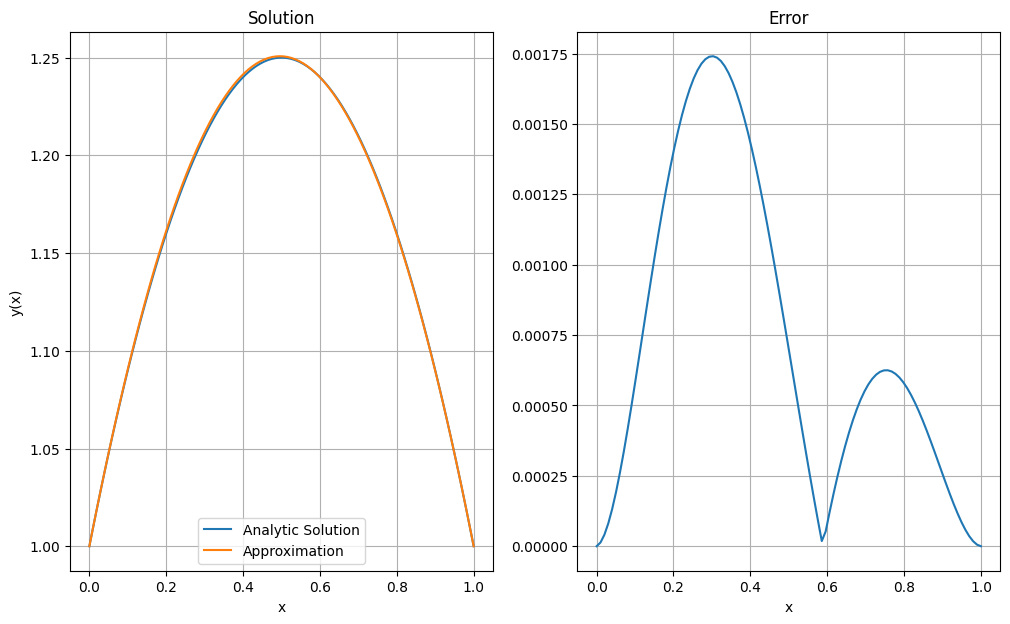

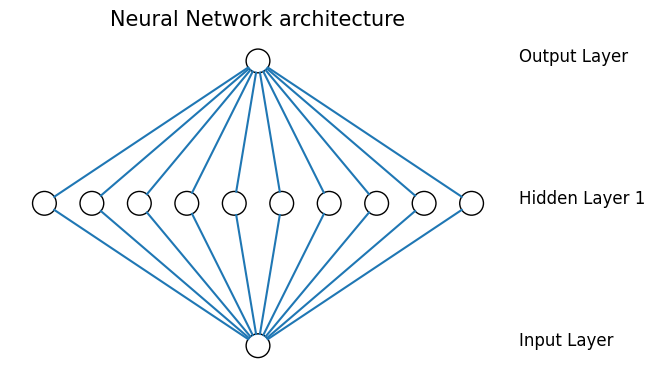

In [9]:
res = y_trial(x,P)
res_analytical = analytic(x)
error = np.reshape(np.abs(res - res_analytical), (100,))
print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

# Plot the results

fig, ax = plt.subplots(1,2,figsize = (12,7))
ax[0].plot(x, res_analytical,label = 'Analytic Solution')
ax[0].plot(x, res[0,:],label = 'Approximation')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y(x)')
ax[0].set_title('Solution')
ax[0].grid()
ax[0].legend()
ax[1].plot(x, error)
ax[1].set_title('Error')
ax[1].grid()
ax[1].set_xlabel('x')
plt.show()
DrawNN([1,num_hidden_neurons,1]).draw()
